# Credit Risk Analysis

Counterparty credit risk assessment for commodity trading.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from src.credit_risk import (
    altman_z_score, probability_of_default, expected_loss,
    unexpected_loss, credit_rating_to_pd, collateral_requirement,
    cds_spread_estimate, credit_var
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Counterparty Database

In [2]:
# sample counterparties for coffee trading
counterparties = pd.DataFrame([
    {
        'name': 'Brazil Coffee Co',
        'country': 'Brazil',
        'exposure': 2_000_000,
        'rating': 'BBB',
        'working_capital': 500_000,
        'total_assets': 3_000_000,
        'retained_earnings': 400_000,
        'ebit': 250_000,
        'market_equity': 1_200_000,
        'total_liabilities': 1_800_000,
        'sales': 5_000_000
    },
    {
        'name': 'Vietnam Beans Ltd',
        'country': 'Vietnam',
        'exposure': 1_500_000,
        'rating': 'BB',
        'working_capital': 200_000,
        'total_assets': 2_000_000,
        'retained_earnings': 150_000,
        'ebit': 120_000,
        'market_equity': 600_000,
        'total_liabilities': 1_400_000,
        'sales': 3_500_000
    },
    {
        'name': 'Colombia Premium',
        'country': 'Colombia',
        'exposure': 3_000_000,
        'rating': 'A',
        'working_capital': 800_000,
        'total_assets': 5_000_000,
        'retained_earnings': 1_000_000,
        'ebit': 500_000,
        'market_equity': 2_500_000,
        'total_liabilities': 2_500_000,
        'sales': 8_000_000
    },
    {
        'name': 'Ethiopia Origins',
        'country': 'Ethiopia',
        'exposure': 800_000,
        'rating': 'B',
        'working_capital': 50_000,
        'total_assets': 800_000,
        'retained_earnings': 30_000,
        'ebit': 40_000,
        'market_equity': 200_000,
        'total_liabilities': 600_000,
        'sales': 1_200_000
    },
    {
        'name': 'Swiss Traders AG',
        'country': 'Switzerland',
        'exposure': 5_000_000,
        'rating': 'AA',
        'working_capital': 2_000_000,
        'total_assets': 10_000_000,
        'retained_earnings': 3_000_000,
        'ebit': 1_500_000,
        'market_equity': 6_000_000,
        'total_liabilities': 4_000_000,
        'sales': 15_000_000
    }
])

print("COUNTERPARTY PORTFOLIO")
print("=" * 60)
print(counterparties[['name', 'country', 'exposure', 'rating']].to_string(index=False))
print(f"\nTotal Exposure: ${counterparties['exposure'].sum():,.0f}")

COUNTERPARTY PORTFOLIO
             name     country  exposure rating
 Brazil Coffee Co      Brazil   2000000    BBB
Vietnam Beans Ltd     Vietnam   1500000     BB
 Colombia Premium    Colombia   3000000      A
 Ethiopia Origins    Ethiopia    800000      B
 Swiss Traders AG Switzerland   5000000     AA

Total Exposure: $12,300,000


## 2. Z-Score Analysis

In [3]:
# calculate Z-scores for all counterparties
z_results = []

for _, cp in counterparties.iterrows():
    z, zone = altman_z_score(
        cp['working_capital'],
        cp['total_assets'],
        cp['retained_earnings'],
        cp['ebit'],
        cp['market_equity'],
        cp['total_liabilities'],
        cp['sales']
    )
    z_results.append({'name': cp['name'], 'z_score': z, 'zone': zone})

z_df = pd.DataFrame(z_results)
counterparties = counterparties.merge(z_df, on='name')

print("ALTMAN Z-SCORE ANALYSIS")
print("=" * 50)
print(f"{'Counterparty':<20} {'Z-Score':>10} {'Zone':>12}")
print("-" * 50)

for _, row in counterparties.iterrows():
    print(f"{row['name']:<20} {row['z_score']:>10.2f} {row['zone']:>12}")

print("\nZ-Score Interpretation:")
print("  > 2.99: Safe Zone")
print("  1.81 - 2.99: Grey Zone")
print("  < 1.81: Distress Zone")

ALTMAN Z-SCORE ANALYSIS
Counterparty            Z-Score         Zone
--------------------------------------------------
Brazil Coffee Co           2.73         Grey
Vietnam Beans Ltd          2.43         Grey
Colombia Premium           3.00         Safe
Ethiopia Origins           1.99         Grey
Swiss Traders AG           3.55         Safe

Z-Score Interpretation:
  > 2.99: Safe Zone
  1.81 - 2.99: Grey Zone
  < 1.81: Distress Zone


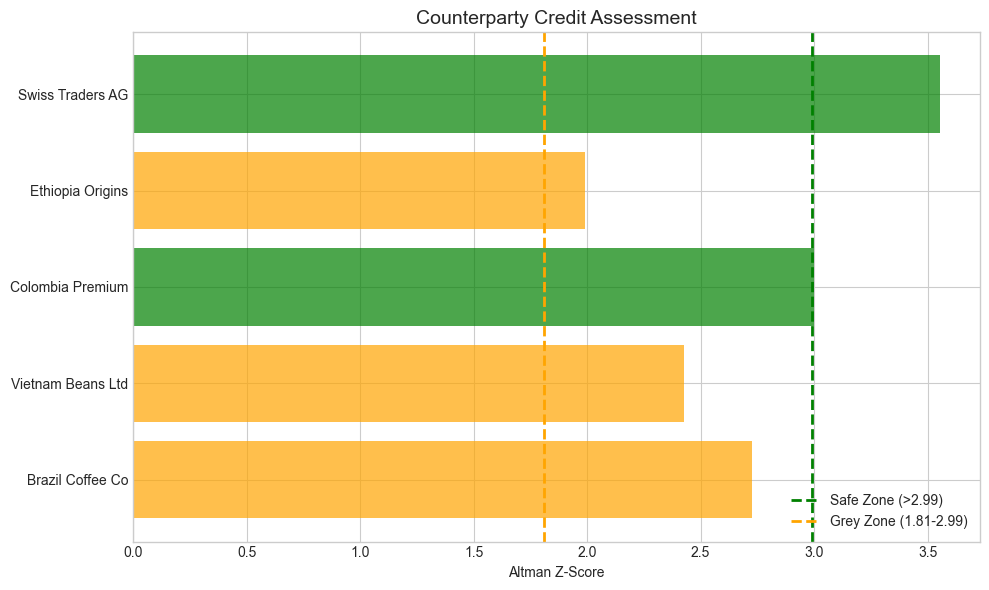

In [4]:
# visualize Z-scores
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'Safe': 'green', 'Grey': 'orange', 'Distress': 'red'}
bar_colors = [colors[z] for z in counterparties['zone']]

bars = ax.barh(counterparties['name'], counterparties['z_score'], color=bar_colors, alpha=0.7)

# zone boundaries
ax.axvline(2.99, color='green', linestyle='--', linewidth=2, label='Safe Zone (>2.99)')
ax.axvline(1.81, color='orange', linestyle='--', linewidth=2, label='Grey Zone (1.81-2.99)')

ax.set_xlabel('Altman Z-Score')
ax.set_title('Counterparty Credit Assessment', fontsize=14)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/z_score_analysis.png', dpi=150)
plt.show()

## 3. Expected Loss Calculation

In [5]:
# calculate PD and expected loss for each counterparty
lgd = 0.45  # standard assumption

el_results = []
for _, cp in counterparties.iterrows():
    pd_rating = credit_rating_to_pd(cp['rating'])
    pd_zscore = probability_of_default(cp['z_score'])
    
    # blend the two PD estimates
    pd_blend = (pd_rating + pd_zscore) / 2
    
    el = expected_loss(pd_blend, lgd, cp['exposure'])
    ul = unexpected_loss(pd_blend, lgd, cp['exposure'])
    
    el_results.append({
        'name': cp['name'],
        'exposure': cp['exposure'],
        'pd_rating': pd_rating,
        'pd_zscore': pd_zscore,
        'pd_blend': pd_blend,
        'expected_loss': el,
        'unexpected_loss': ul
    })

el_df = pd.DataFrame(el_results)

print("EXPECTED LOSS ANALYSIS")
print("=" * 80)
print(f"{'Counterparty':<20} {'Exposure':>12} {'PD':>8} {'EL':>12} {'UL':>12}")
print("-" * 80)

for _, row in el_df.iterrows():
    print(f"{row['name']:<20} ${row['exposure']:>10,.0f} {row['pd_blend']:>7.2%} ${row['expected_loss']:>10,.0f} ${row['unexpected_loss']:>10,.0f}")

print("-" * 80)
print(f"{'TOTAL':<20} ${el_df['exposure'].sum():>10,.0f} {' '*7} ${el_df['expected_loss'].sum():>10,.0f} ${el_df['unexpected_loss'].sum():>10,.0f}")

EXPECTED LOSS ANALYSIS
Counterparty             Exposure       PD           EL           UL
--------------------------------------------------------------------------------
Brazil Coffee Co     $ 2,000,000  22.33% $   200,959 $   266,156
Vietnam Beans Ltd    $ 1,500,000  26.39% $   178,164 $   209,182
Colombia Premium     $ 3,000,000  18.92% $   255,452 $   376,597
Ethiopia Origins     $   800,000  33.23% $   119,623 $   115,909
Swiss Traders AG     $ 5,000,000  12.94% $   291,210 $   530,510
--------------------------------------------------------------------------------
TOTAL                $12,300,000         $ 1,045,408 $ 1,498,354


## 4. Collateral Requirements

In [6]:
# calculate collateral for each counterparty
collateral_results = []

for _, cp in counterparties.iterrows():
    req = collateral_requirement(cp['exposure'], cp['rating'])
    collateral_results.append({
        'name': cp['name'],
        'exposure': cp['exposure'],
        'rating': cp['rating'],
        'collateral': req,
        'coverage': req / cp['exposure']
    })

coll_df = pd.DataFrame(collateral_results)

print("COLLATERAL REQUIREMENTS")
print("=" * 70)
print(f"{'Counterparty':<20} {'Rating':>8} {'Exposure':>12} {'Collateral':>12} {'%':>8}")
print("-" * 70)

for _, row in coll_df.iterrows():
    print(f"{row['name']:<20} {row['rating']:>8} ${row['exposure']:>10,.0f} ${row['collateral']:>10,.0f} {row['coverage']:>7.0%}")

print("-" * 70)
print(f"{'TOTAL':<20} {' '*8} ${coll_df['exposure'].sum():>10,.0f} ${coll_df['collateral'].sum():>10,.0f}")

COLLATERAL REQUIREMENTS
Counterparty           Rating     Exposure   Collateral        %
----------------------------------------------------------------------
Brazil Coffee Co          BBB $ 2,000,000 $   240,000     12%
Vietnam Beans Ltd          BB $ 1,500,000 $   270,000     18%
Colombia Premium            A $ 3,000,000 $   240,000      8%
Ethiopia Origins            B $   800,000 $   200,000     25%
Swiss Traders AG           AA $ 5,000,000 $   250,000      5%
----------------------------------------------------------------------
TOTAL                         $12,300,000 $ 1,200,000


## 5. CDS Spread Estimation

In [7]:
# estimate CDS spreads
cds_results = []

for _, row in el_df.iterrows():
    spread = cds_spread_estimate(row['pd_blend'], lgd=0.45)
    annual_cost = row['exposure'] * spread / 10000  # spread in bps
    
    cds_results.append({
        'name': row['name'],
        'exposure': row['exposure'],
        'pd': row['pd_blend'],
        'cds_spread': spread,
        'annual_cost': annual_cost
    })

cds_df = pd.DataFrame(cds_results)

print("CDS PROTECTION COSTS")
print("=" * 70)
print(f"{'Counterparty':<20} {'Exposure':>12} {'Spread (bps)':>12} {'Annual Cost':>12}")
print("-" * 70)

for _, row in cds_df.iterrows():
    print(f"{row['name']:<20} ${row['exposure']:>10,.0f} {row['cds_spread']:>11.0f} ${row['annual_cost']:>10,.0f}")

print("-" * 70)
print(f"{'TOTAL HEDGING COST':<20} {' '*23} ${cds_df['annual_cost'].sum():>10,.0f}")

CDS PROTECTION COSTS
Counterparty             Exposure Spread (bps)  Annual Cost
----------------------------------------------------------------------
Brazil Coffee Co     $ 2,000,000        1005 $   200,959
Vietnam Beans Ltd    $ 1,500,000        1188 $   178,164
Colombia Premium     $ 3,000,000         852 $   255,452
Ethiopia Origins     $   800,000        1495 $   119,623
Swiss Traders AG     $ 5,000,000         582 $   291,210
----------------------------------------------------------------------
TOTAL HEDGING COST                           $ 1,045,408


## 6. Portfolio Credit VaR

In [8]:
# calculate portfolio credit VaR
exposures = el_df['exposure'].values
pds = el_df['pd_blend'].values
lgds = np.full(len(pds), 0.45)

cvar = credit_var(exposures, pds, lgds, correlation=0.20, n_sims=50000)

print("PORTFOLIO CREDIT VAR")
print("=" * 50)
print(f"Total Exposure: ${sum(exposures):,.0f}")
print(f"Number of Counterparties: {len(exposures)}")
print(f"Average PD: {np.mean(pds):.2%}")
print(f"Asset Correlation: 20%\n")

print(f"Expected Loss (mean): ${cvar['expected_loss']:>12,.0f}")
print(f"99% Credit VaR: ${cvar['credit_var']:>12,.0f}")
print(f"Worst Case: ${cvar['worst_case']:>12,.0f}")
print(f"\nUnexpected Loss (99%): ${cvar['credit_var'] - cvar['expected_loss']:>12,.0f}")

PORTFOLIO CREDIT VAR
Total Exposure: $12,300,000
Number of Counterparties: 5
Average PD: 22.76%
Asset Correlation: 20%

Expected Loss (mean): $   1,045,285
99% Credit VaR: $   4,860,000
Worst Case: $   5,535,000

Unexpected Loss (99%): $   3,814,715


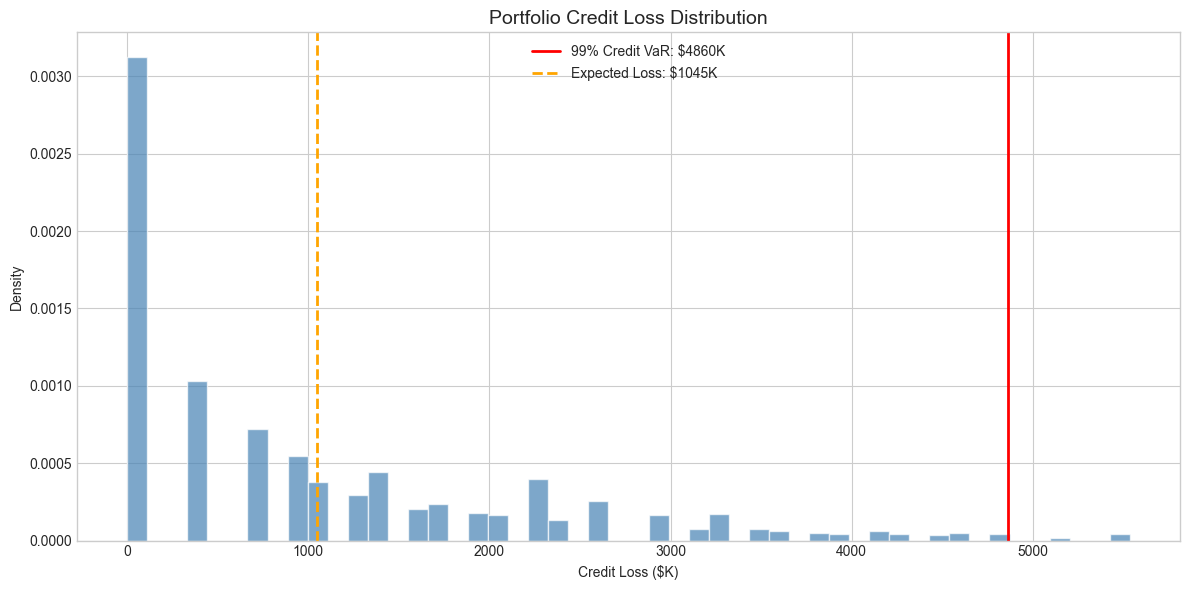

In [9]:
# simulate loss distribution
n_sims = 50000
correlation = 0.20

np.random.seed(42)
losses = []

for _ in range(n_sims):
    z = np.random.normal()
    eps = np.random.normal(size=len(exposures))
    asset = np.sqrt(correlation) * z + np.sqrt(1 - correlation) * eps
    thresholds = stats.norm.ppf(pds)
    defaults = asset < thresholds
    loss = np.sum(defaults * exposures * lgds)
    losses.append(loss)

losses = np.array(losses)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(losses / 1000, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')

var_99 = np.percentile(losses, 99)
ax.axvline(var_99 / 1000, color='red', linewidth=2, label=f'99% Credit VaR: ${var_99/1000:.0f}K')
ax.axvline(losses.mean() / 1000, color='orange', linewidth=2, linestyle='--', label=f'Expected Loss: ${losses.mean()/1000:.0f}K')

ax.set_xlabel('Credit Loss ($K)')
ax.set_ylabel('Density')
ax.set_title('Portfolio Credit Loss Distribution', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/credit_loss_dist.png', dpi=150)
plt.show()

## 7. Concentration Risk

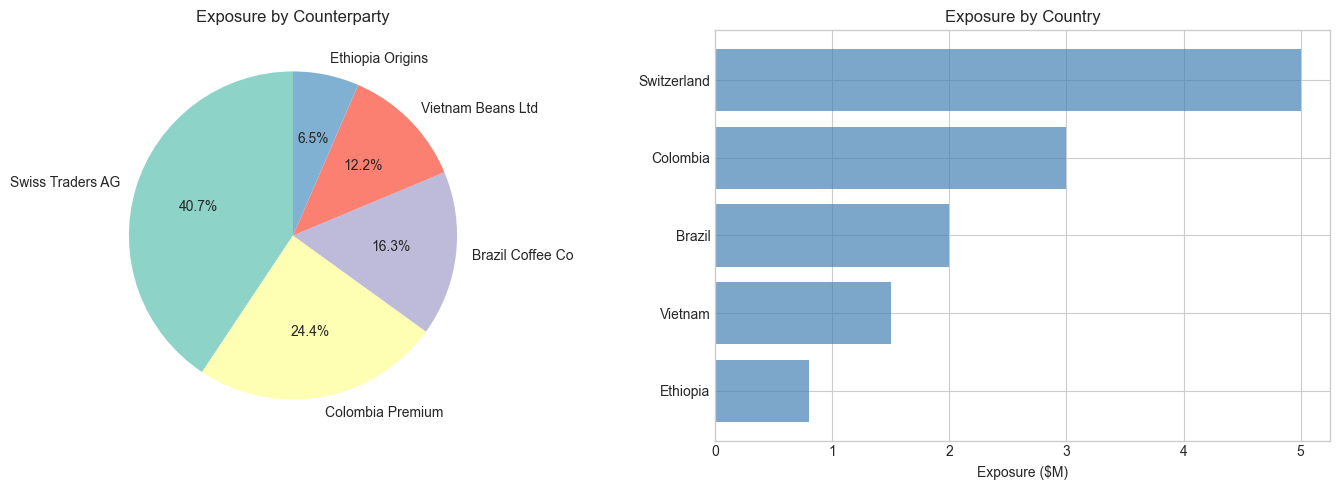

CONCENTRATION METRICS
Largest Single Exposure: 40.7%
Top 3 Counterparties: 81.3%
HHI Index: 2703


In [10]:
# analyze concentration
total_exposure = counterparties['exposure'].sum()

# by counterparty
concentration = counterparties[['name', 'exposure']].copy()
concentration['pct'] = concentration['exposure'] / total_exposure
concentration = concentration.sort_values('exposure', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# pie chart
axes[0].pie(concentration['exposure'], labels=concentration['name'], 
            autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
axes[0].set_title('Exposure by Counterparty', fontsize=12)

# bar chart by country
country_exp = counterparties.groupby('country')['exposure'].sum().sort_values(ascending=True)
axes[1].barh(country_exp.index, country_exp.values / 1e6, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Exposure ($M)')
axes[1].set_title('Exposure by Country', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/concentration_risk.png', dpi=150)
plt.show()

print("CONCENTRATION METRICS")
print("=" * 40)
print(f"Largest Single Exposure: {concentration['pct'].iloc[0]:.1%}")
print(f"Top 3 Counterparties: {concentration['pct'].head(3).sum():.1%}")
print(f"HHI Index: {(concentration['pct']**2).sum()*10000:.0f}")

## 8. New Counterparty Assessment

In [11]:
# assess a new potential supplier
new_supplier = {
    'name': 'Indonesia Beans',
    'exposure': 1_000_000,
    'working_capital': 100_000,
    'total_assets': 1_500_000,
    'retained_earnings': 80_000,
    'ebit': 60_000,
    'market_equity': 400_000,
    'total_liabilities': 1_100_000,
    'sales': 2_000_000
}

print("NEW COUNTERPARTY ASSESSMENT")
print("=" * 50)
print(f"Name: {new_supplier['name']}")
print(f"Proposed Exposure: ${new_supplier['exposure']:,.0f}\n")

# calculate Z-score
z, zone = altman_z_score(
    new_supplier['working_capital'],
    new_supplier['total_assets'],
    new_supplier['retained_earnings'],
    new_supplier['ebit'],
    new_supplier['market_equity'],
    new_supplier['total_liabilities'],
    new_supplier['sales']
)

print(f"Altman Z-Score: {z:.2f}")
print(f"Risk Zone: {zone}")

# estimate PD
pd_est = probability_of_default(z)
print(f"Estimated PD: {pd_est:.2%}")

# expected loss
el = expected_loss(pd_est, 0.45, new_supplier['exposure'])
print(f"Expected Loss: ${el:,.0f}")

# recommended actions
print("\nRECOMMENDATIONS:")
print("-" * 30)

if zone == 'Safe':
    print("✓ Approved with standard terms")
elif zone == 'Grey':
    coll = collateral_requirement(new_supplier['exposure'], 'BB')
    print(f"⚠ Conditional approval:")
    print(f"  - Require ${coll:,.0f} collateral")
    print(f"  - Quarterly financial review")
    print(f"  - Consider CDS protection")
else:
    print("✗ High risk - recommend declining or:")
    print(f"  - Reduce exposure to ${new_supplier['exposure']*0.3:,.0f}")
    print(f"  - Require 50% advance payment")
    print(f"  - Letter of credit mandatory")

NEW COUNTERPARTY ASSESSMENT
Name: Indonesia Beans
Proposed Exposure: $1,000,000

Altman Z-Score: 1.84
Risk Zone: Grey
Estimated PD: 66.00%
Expected Loss: $296,986

RECOMMENDATIONS:
------------------------------
⚠ Conditional approval:
  - Require $180,000 collateral
  - Quarterly financial review
  - Consider CDS protection


## 9. Summary Report

In [12]:
print("\n" + "=" * 70)
print("CREDIT RISK SUMMARY REPORT")
print("=" * 70)

# risk breakdown by zone
zone_exposure = counterparties.groupby('zone')['exposure'].sum()

summary = f"""
PORTFOLIO OVERVIEW:
-------------------
Total Counterparties: {len(counterparties)}
Total Exposure: ${counterparties['exposure'].sum():,.0f}

EXPOSURE BY RISK ZONE:
----------------------
Safe Zone: ${zone_exposure.get('Safe', 0):,.0f}
Grey Zone: ${zone_exposure.get('Grey', 0):,.0f}
Distress Zone: ${zone_exposure.get('Distress', 0):,.0f}

EXPECTED LOSSES:
----------------
Total Expected Loss: ${el_df['expected_loss'].sum():,.0f}
Total Unexpected Loss: ${el_df['unexpected_loss'].sum():,.0f}
99% Credit VaR: ${cvar['credit_var']:,.0f}

COLLATERAL & HEDGING:
---------------------
Required Collateral: ${coll_df['collateral'].sum():,.0f}
Annual CDS Cost: ${cds_df['annual_cost'].sum():,.0f}

CONCENTRATION:
--------------
Largest Counterparty: {concentration.iloc[0]['name']} ({concentration.iloc[0]['pct']:.1%})
Top 3 Concentration: {concentration['pct'].head(3).sum():.1%}

RECOMMENDATIONS:
----------------
1. Monitor {counterparties[counterparties['zone'] != 'Safe']['name'].tolist()} closely
2. Consider reducing single-name concentration above 25%
3. Review collateral adequacy quarterly
4. Maintain credit reserves of ${el_df['expected_loss'].sum() * 1.5:,.0f}
"""

print(summary)


CREDIT RISK SUMMARY REPORT

PORTFOLIO OVERVIEW:
-------------------
Total Counterparties: 5
Total Exposure: $12,300,000

EXPOSURE BY RISK ZONE:
----------------------
Safe Zone: $8,000,000
Grey Zone: $4,300,000
Distress Zone: $0

EXPECTED LOSSES:
----------------
Total Expected Loss: $1,045,408
Total Unexpected Loss: $1,498,354
99% Credit VaR: $4,860,000

COLLATERAL & HEDGING:
---------------------
Required Collateral: $1,200,000
Annual CDS Cost: $1,045,408

CONCENTRATION:
--------------
Largest Counterparty: Swiss Traders AG (40.7%)
Top 3 Concentration: 81.3%

RECOMMENDATIONS:
----------------
1. Monitor ['Brazil Coffee Co', 'Vietnam Beans Ltd', 'Ethiopia Origins'] closely
2. Consider reducing single-name concentration above 25%
3. Review collateral adequacy quarterly
4. Maintain credit reserves of $1,568,111

